In [1]:
# basic
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
# pre processing
from sklearn import preprocessing as pre
# NN
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import MSELoss
from torch_geometric.nn import GCNConv
# val and plot
from torchmetrics.regression import R2Score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from loguru import logger as log
from val import calculate_metrics
# plot
import matplotlib.pyplot as plt

In [27]:
SEED = 1345
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(SEED)
plt.style.use('seaborn-whitegrid')
pd.set_option('display.float_format', '{:.16f}'.format)

## Data

In [3]:
from data import load_dataset
from torch_geometric_temporal.signal import temporal_signal_split

In [4]:
train_dataset = load_dataset('../../data/graph_designer/train_test/dataset_train.pkl')

In [5]:
test_dataset = load_dataset('../../data/graph_designer/train_test/dataset_test.pkl')

In [6]:
df_nodes = pd.read_csv('../../data/graph_designer/train_test/df_nodes_selected.csv')
nodes = list(df_nodes.tensor_idx.values)

In [7]:
df_nodes_loader = pd.read_csv('../../data/graph_designer/train_test/df_nodes_selected_loader.csv')
df_nodes_loader.head()

,time,day,partition,partition_nn,carregamento_node_694,carregamento_node_2772,carregamento_node_1203,carregamento_node_592,carregamento_node_561
0,2024-03-01 05:00:00,1,train,train,12.166667,8.666667,0.000000,0.166667,20.166667
1,2024-03-01 05:05:00,1,train,train,26.583333,8.666667,0.000000,4.833333,32.833333
2,2024-03-01 05:10:00,1,train,train,48.833333,19.166667,0.000000,8.000000,45.916667
3,2024-03-01 05:15:00,1,train,train,76.333333,22.333333,3.916667,12.750000,67.500000
4,2024-03-01 05:20:00,1,train,train,97.250000,33.250000,12.916667,17.250000,97.833333


## Model

In [8]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.linear = nn.Linear(hidden_channels, out_channels)

    def forward(self, x: Tensor, edge_index: Tensor,  edge_weight: Tensor) -> Tensor:
        # x: Node feature matrix of shape [num_nodes, in_channels]
        # edge_index: Graph connectivity matrix of shape [2, num_edges]
        #x = self.conv1(x, edge_index, edge_weight)
        x = self.conv1(x, edge_index, edge_weight)
        x =  F.relu(x)
        x = self.linear(x) 
        
        return x      

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [10]:
# define model
model =  GCN(in_channels=36,
             hidden_channels=128,
             out_channels=12).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
print(model)

GCN(
  (conv1): GCNConv(36, 128)
  (linear): Linear(in_features=128, out_features=12, bias=True)
)


In [12]:
number_epochs=100
training_loss = []
for epoch in tqdm(range(number_epochs)):
    model.train()
    cost = 0
    for time, snapshot in enumerate(train_dataset): # faz o treino em cada bath temporal
        snapshot.to(device)
        #print(f"snapshot.x: {snapshot.x.shape}")
        y_hat = model(snapshot.x, 
                      snapshot.edge_index, 
                      snapshot.edge_attr)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)

    cost = cost / (time+1)
    training_loss.append(cost.cpu().data.numpy())

    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100% 100/100 [01:00<00:00,  1.65it/s]


2024-05-31 20:42:10.721 | INFO     | __main__:<module>:1 - min cost train MSE: 267.04400634765625


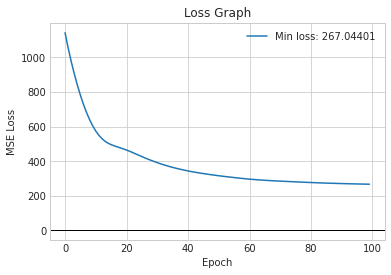

In [13]:
log.info(f"min cost train MSE: {np.min(training_loss)}")
torch.save(model.state_dict(), f'../../outputs/weights/gcn.pth')

plt.plot(training_loss, 
         label=f'Min loss: {min(training_loss):.5f}')# 276
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.legend()
plt.show()
#plt.savefig(f'{root_folder}{model_name}_{num_timesteps_in}_pred_{num_timesteps_out}.png')

### Test

In [14]:
scores_error = {'mae': [], 'mse': [], 'r2': [], 'mape': []}
targets = []
model.eval()
cost, time = 0, 0

dfs_pred = []

for time, snapshot in tqdm(enumerate(test_dataset)):
    snapshot.to('cpu')
        
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    y_true = snapshot.y.cpu().data.numpy()
    y_pred = y_hat.cpu().data.numpy()
    
    scores_error['mse'].append(mean_squared_error(y_true[nodes,:], y_pred[nodes,:]))
    scores_error['mae'].append(mean_absolute_error(y_true[nodes,:], y_pred[nodes,:]))
    scores_error['r2'].append(r2_score(y_true[nodes,:], y_pred[nodes,:]))
    scores_error['mape'].append(mean_absolute_percentage_error(y_true[nodes,:], y_pred[nodes,:]))
    
    targets.append({'true': y_true,
                    'pred': y_pred})
        
    df_prediction = pd.DataFrame()
    df_prediction['time'] = test_dataset.target_time[time]
    for node in nodes:
        df_prediction[f'y_pred_{node}'] = y_pred[node,:]
    dfs_pred.append(df_prediction)
                
cost = cost / (time+1)
cost = cost.item()
log.info("MSE test: {:.4f}".format(cost))

33it [00:00, 197.79it/s]
2024-05-31 20:42:10.999 | INFO     | __main__:<module>:33 - MSE test: 324.8070


In [15]:
targets[0]['pred'][nodes,:].shape

(5, 12)

In [16]:
df_forecasting = pd.concat(dfs_pred, ignore_index=True)
df_forecasting.head()

,time,y_pred_694,y_pred_2772,y_pred_1203,y_pred_592,y_pred_561
0,2024-03-07 12:00:00,122.412720,131.498856,44.956856,16.780514,67.678146
1,2024-03-07 12:05:00,128.593994,146.196350,48.644413,17.271357,71.701180
2,2024-03-07 12:10:00,131.322418,144.309464,49.258369,17.918629,71.466644
3,2024-03-07 12:15:00,120.942764,133.009598,45.223675,17.012665,68.587112
4,2024-03-07 12:20:00,131.805984,147.068390,50.770142,18.293886,72.370934


In [17]:
df_nodes_loader['time'] = pd.to_datetime(df_nodes_loader['time'], format='%Y-%m-%d %H:%M:%S')

In [18]:
## join with true dataset
df_nodes_loader_join = df_nodes_loader.merge(df_forecasting, 
                                        on='time', 
                                        how='left')

In [19]:
df_test_val = df_nodes_loader_join.query(" partition == 'test' ")

In [20]:
df_test_val.head()

,time,day,partition,partition_nn,carregamento_node_694,carregamento_node_2772,carregamento_node_1203,carregamento_node_592,carregamento_node_561,y_pred_694,y_pred_2772,y_pred_1203,y_pred_592,y_pred_561
1668,2024-03-08 00:00:00,8,test,test,26.666667,24.583333,0.25,2.5,17.583333,22.615602,25.116711,2.908926,1.914155,13.278063
1669,2024-03-08 00:05:00,8,test,test,24.416667,24.833333,0.50,2.5,11.416667,30.142242,34.864315,3.359843,2.415550,17.184984
1670,2024-03-08 00:10:00,8,test,test,18.000000,18.000000,0.50,1.5,11.166667,21.921837,17.518751,2.298645,1.942118,15.276021
1671,2024-03-08 00:15:00,8,test,test,18.250000,12.916667,0.50,1.5,9.333333,19.599541,16.416412,3.078542,2.600010,12.653323
1672,2024-03-08 00:20:00,8,test,test,15.416667,8.666667,0.50,1.5,9.250000,21.218191,16.612223,2.506094,2.229895,14.562609


In [31]:
# save
df_test_val.to_csv('../../outputs/forecasting/gcn_forecasting.csv', index=False)

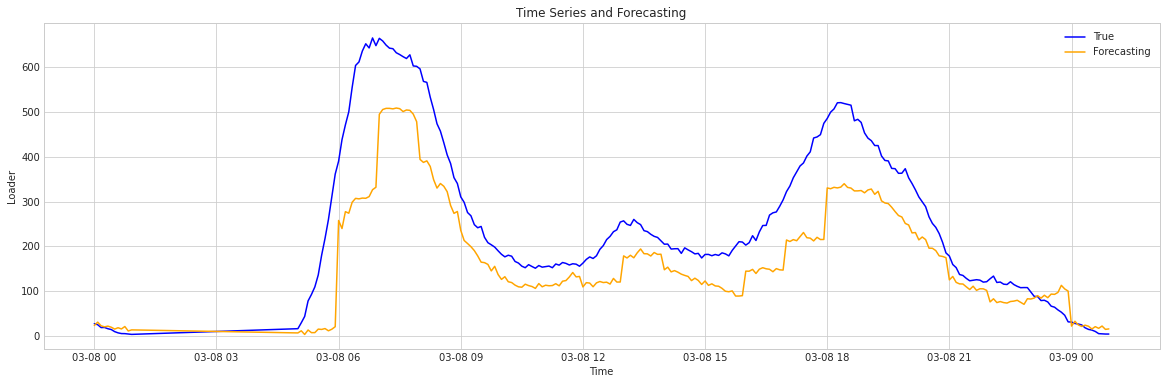

In [21]:
plt.figure(figsize=(20, 6))
plt.plot(df_test_val.time, df_test_val.carregamento_node_694, label=f'True', color='blue')
plt.plot(df_test_val.time, df_test_val.y_pred_694, label=f'Forecasting', color='orange')
plt.xlabel('Time')
plt.ylabel('Loader')
plt.title('Time Series and Forecasting')
plt.legend()
plt.show()

In [23]:
dfs_results = []
for node in nodes:
    res = calculate_metrics(df_test_val[f"carregamento_node_{node}"], df_test_val[f"y_pred_{node}"])
    res['node'] = node
    dfs_results.append(o)

In [28]:
df_result = pd.DataFrame(dfs_results)
df_result.head()

,mse,mae,rmse,mape,r2,node
0,12913.2308760767446074,87.3092646977258084,113.6363976729143985,0.4465453035387485,0.5829101696393981,694
1,4202.5894843773303364,47.0010552519843685,64.8273822113567206,0.3277512097974237,0.7642278669107877,2772
2,248.4077557372305023,11.6299402045982845,15.7609566885145167,39303114703628.8984375000000000,0.8247200258805188,1203
3,197.9243493577143624,8.9642927777317780,14.0685588941339113,98997798865449.1562500000000000,0.3209499615241636,592
4,3650.7662428977655509,43.8448141305534875,60.4215710065351175,0.4656288944242000,0.7019470030872652,561


In [29]:
df_result.pivot_table(index='node', aggfunc='mean').reset_index()

,node,mae,mape,mse,r2,rmse
0,561,43.8448141305534875,0.4656288944242000,3650.7662428977655509,0.7019470030872652,60.4215710065351175
1,592,8.9642927777317780,98997798865449.1562500000000000,197.9243493577143624,0.3209499615241636,14.0685588941339113
2,694,87.3092646977258084,0.4465453035387485,12913.2308760767446074,0.5829101696393981,113.6363976729143985
3,1203,11.6299402045982845,39303114703628.8984375000000000,248.4077557372305023,0.8247200258805188,15.7609566885145167
4,2772,47.0010552519843685,0.3277512097974237,4202.5894843773303364,0.7642278669107877,64.8273822113567206


In [30]:
df_result.mean()

mse              4242.5837416893573391
mae                39.7498734125187383
rmse               53.7429732946909340
mape   27660182713815.8593750000000000
r2                  0.6389510054084266
node             1164.4000000000000909
dtype: float64

In [32]:
df_result.to_csv('../../outputs/forecasting/gcn_metrics.csv', index=False)